In [3]:
import logging
import math
import numpy as np
import pandas as pd
import numpy as np
from scipy.interpolate import UnivariateSpline
from matplotlib import pyplot as plt
from scipy.stats import rankdata
from sklearn.preprocessing import normalize
from math import log
from mpl_toolkits.axes_grid1 import make_axes_locatable   

class Logger(object):
    def __init__(self, log_file_name, log_level, logger_name):
        self.__logger = logging.getLogger(logger_name)
        self.__logger.setLevel(log_level)
        file_handler = logging.FileHandler(log_file_name)
        console_handler = logging.StreamHandler()
        formatter = logging.Formatter(
            '[%(asctime)s] - [%(filename)s line:%(lineno)d] : %(message)s')
        file_handler.setFormatter(formatter)
        console_handler.setFormatter(formatter)
        self.__logger.addHandler(file_handler)
        self.__logger.addHandler(console_handler)

    def get_log(self):
        return self.__logger

def scale(X, x_min, x_max):
    nom = (X-X.min(axis=0))*(x_max-x_min)
    denom = X.max(axis=0) - X.min(axis=0)
    denom[denom==0] = 1
    return x_min + nom/denom

logger = Logger('C:\\Users\\bird\\Desktop\\cancer_project_github\\log.txt', log_level=logging.DEBUG, logger_name="CIFAR").get_log()

clinical_file = 'C:\\Users\\bird\\Desktop\\cancer_project_github\\cancer_data\\clinical_sample_data.csv'
mRNA_file = 'C:\\Users\\bird\\Desktop\\cancer_project_github\\cancer_data\data_mRNA_seq_fpkm_polya_56M.csv'

# clinical_244_file = 'C:\\Users\\bird\Desktop\\cancer_project_github\\cancer_data\\clinical_244_data.csv'
# mRNA_244_file = 'C:\\Users\\bird\\Desktop\\cancer_project_github\\cancer_data\\data_mRNA_244.csv'

clinical_231_file = 'C:\\Users\\bird\Desktop\\cancer_project_github\\cancer_data\\clinical_231_data.csv'
mRNA_231_file = 'C:\\Users\\bird\\Desktop\\cancer_project_github\\cancer_data\\data_mRNA_231_sort_with_sensitive.csv'

clinical_df=pd.read_csv(clinical_231_file)
mRNA_231_df=pd.read_csv(mRNA_231_file)


(231, 19165)
(231, 231)
53361
53130


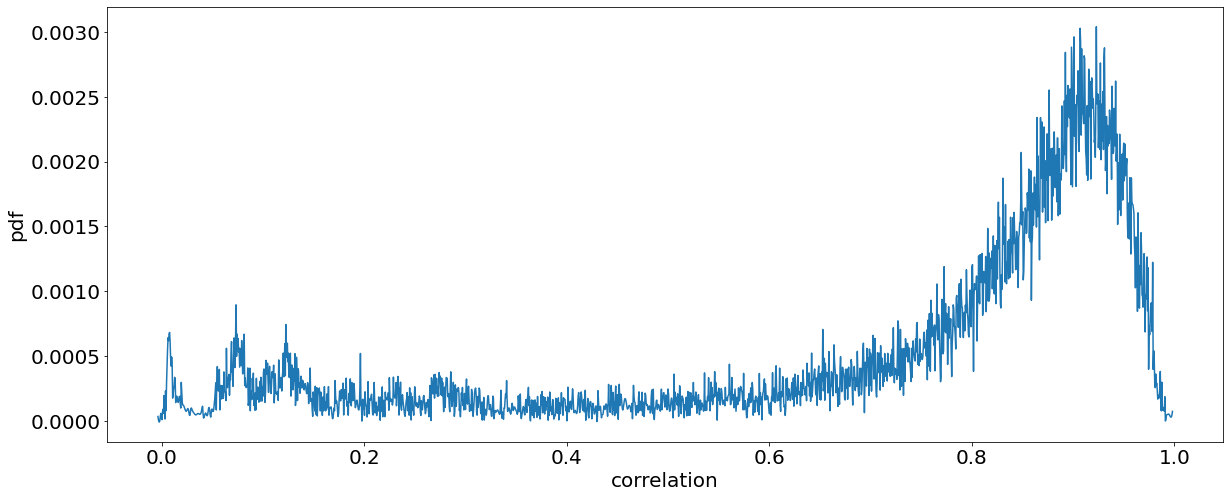

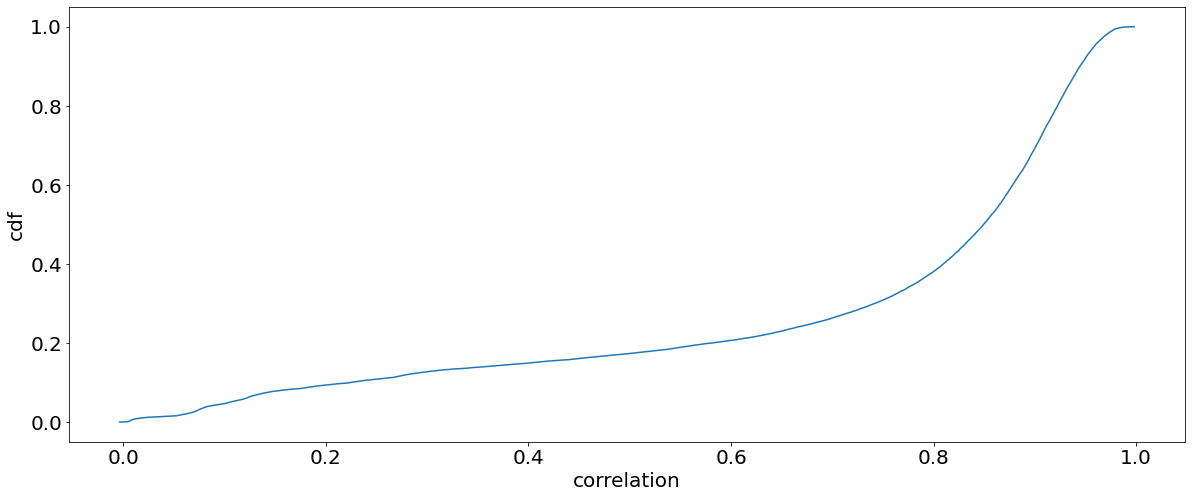

In [29]:


mRNA_231_df=pd.read_csv(mRNA_231_file)
# print(mRNA_244_df)
# print(mRNA_231_df)
mRNA_231_df = mRNA_231_df.set_index('SAMPLE_ID')
# print(mRNA_244_df['0'].tolist())
# print(mRNA_231_df)
patient_mRNA = []
for column in mRNA_231_df:
    
#     print(mRNA_244_df[column].tolist())
    patient_mRNA.append(mRNA_231_df[column].tolist())
# print(patient_mRNA[0])
patient_np = np.asarray(patient_mRNA)
# r = np.corrcoef(patient_np, patient_np)
# r

print(patient_np.shape)

# sidx = np.argsort(patient_np, axis=1)
# m,n = patient_np.shape
# out = np.empty((m,n),dtype=int)
# sidx = np.argsort(patient_np, axis=0)
# out[sidx, np.arange(n)] = np.arange(m)[:,None]
# oned = patient_np.flatten()
# print(oned.shape)
# ranks = (rankdata(oned, method='dense') - 1).astype(int)  # normalisation method 2
# print('ranks')
# print(ranks.shape)
# patient_np =  np.reshape(ranks, (-1, 19293))
# print(patient_np.shape)
# print(patient_np)
# patient_np = scale(patient_np, 0, 100) 


# correlations = []
# for i in range(0, len(patient_mRNA)):
#     for j in  range(i+1, len(patient_mRNA)):
#         i_np = np.asarray(patient_mRNA[i])
#         j_np = np.asarray(patient_mRNA[j])
#         r = np.corrcoef(i_np, j_np)
        
#         correlations.append(r[0,1])
#         if r[0,1] < 0.4:
#             print('----')
#             print(i)
#             print(j)
#             print('----')
#             print(r[0,1])
# correlations = [ round(elem, 2) for elem in correlations ]
# print(correlations)

correlations = np.corrcoef(patient_np, patient_np)[0:231,0:231]
print(correlations.shape)
correlations = correlations.flatten()
print(len(correlations))
correlations = list(filter(lambda a: a <0.99999, correlations))
print(len(correlations))

n = 2000
s = np.asarray(correlations)   # generate your data sample with N elements
p, x = np.histogram(s, bins=n) # bin it into n = N//10 bins
x = x[:-1] + (x[1] - x[0])/2   # convert bin edges to centers
f = UnivariateSpline(x, p, s=n)
y = f(x)/len(correlations)

cdfy = np.cumsum(y)

plt.figure(figsize=(20,8))
plt.xlabel('correlation', fontsize=20)
plt.ylabel('pdf', fontsize=20)
plt.plot(x, y)
plt.show()


plt.figure(figsize=(20,8))
plt.xlabel('correlation', fontsize=20)
plt.ylabel('cdf', fontsize=20)
plt.plot(x, cdfy)
plt.show()


In [28]:
def sort_within_each_cancer(patient_np, norm = ''):
    if norm == 'scale_and_bin':
        patient_np = np.floor(scale(patient_np, 0, 100))
    r = np.corrcoef(patient_np, patient_np)
    correlation_matrix = r[0:117, 0:117] #LN 0-117, Bone 117-191, Liver 191-231
    # print(correlation_matrix)
    corr_means = correlation_matrix.mean(axis=0)
    # x = dict(zip(corr_means, range(0,117)))
    # print(x)
    ranks = np.argsort(-corr_means)
    # print(ranks)
    correlation_matrix = r[117:191, 117:191] #LN 0-117, Bone 117-191, Liver 191-231
    # print(correlation_matrix)
    corr_means = correlation_matrix.mean(axis=0)

    ranks_t= np.argsort(-corr_means) + 117
    ranks = np.concatenate([ranks, ranks_t]) 
    # print(ranks)
    correlation_matrix = r[191:231, 191:231] #LN 0-117, Bone 117-191, Liver 191-231
    # print(correlation_matrix)
    corr_means = correlation_matrix.mean(axis=0)

    ranks_t = np.argsort(-corr_means) + 191
    ranks = np.concatenate([ranks, ranks_t]) 
    # print(ranks)
    # print(len(ranks))
    # print(ranks.min())
    # print(ranks.max())

    correlation_matrix = r[0:231, 0:231]
    correlation_matrix = correlation_matrix[:, ranks][ranks]
    # print(correlation_matrix)
    # pd.DataFrame(correlation_matrix).to_csv('C:\\Users\\bird\\Desktop\\cancer_project_github\\cancer_data\\temp.csv')
    return correlation_matrix


def sort_with_all_cancers(patient_np, norm = ''):
    if norm == 'scale_and_bin':
        patient_np = np.floor(scale(patient_np, 0, 100))
    r = np.corrcoef(patient_np, patient_np)
    correlation_matrix = r[ 0:231,0:117] #LN 0-117, Bone 117-191, Liver 191-231
#     print(len(correlation_matrix[0]))
    corr_means = correlation_matrix.mean(axis=0)
    # print(x)
    ranks = np.argsort(-corr_means)
#     print(ranks)
#     print(len(ranks))
    correlation_matrix = r[0:231, 117:191] #LN 0-117, Bone 117-191, Liver 191-231
    # print(correlation_matrix)
    corr_means = correlation_matrix.mean(axis=0)

    ranks_t= np.argsort(-corr_means) + 117
    ranks = np.concatenate([ranks, ranks_t]) 

    correlation_matrix = r[0:231, 191:231] #LN 0-117, Bone 117-191, Liver 191-231
    # print(correlation_matrix)
    corr_means = correlation_matrix.mean(axis=0)

    ranks_t = np.argsort(-corr_means) + 191
    ranks = np.concatenate([ranks, ranks_t]) 
#     print(ranks)
#     print(len(ranks))
    # print(ranks.min())
    # print(ranks.max())

    correlation_matrix = r[0:231, 0:231]
    correlation_matrix = correlation_matrix[:, ranks][ranks]
    # print(correlation_matrix)
    # pd.DataFrame(correlation_matrix).to_csv('C:\\Users\\bird\\Desktop\\cancer_project_github\\cancer_data\\temp.csv')
    return correlation_matrix


Graph Plot A,B,C

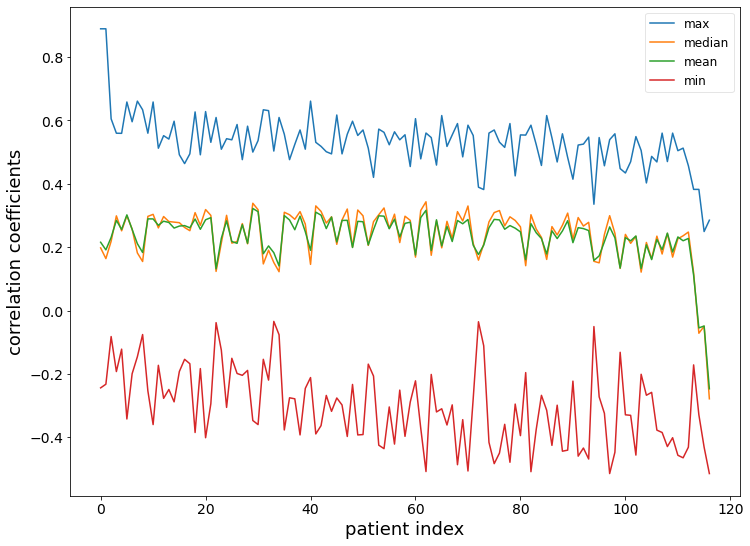

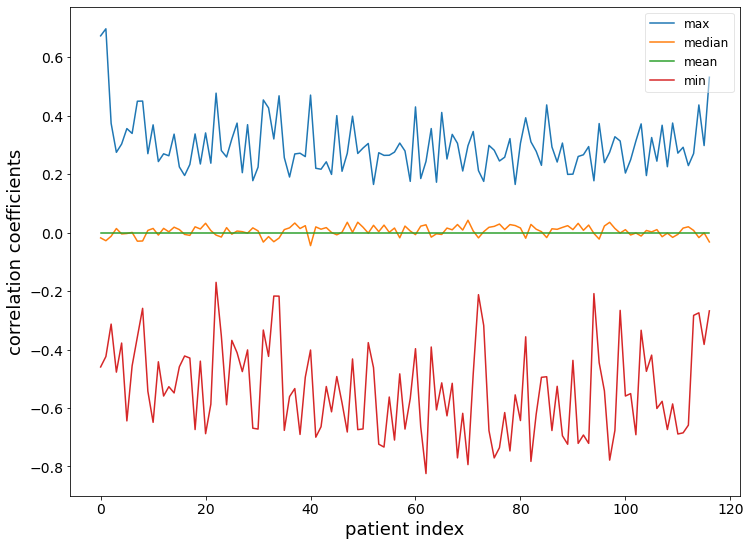

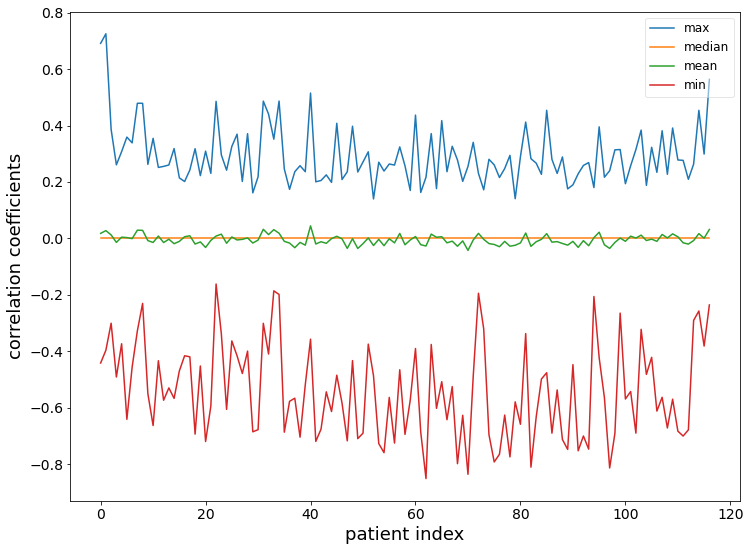

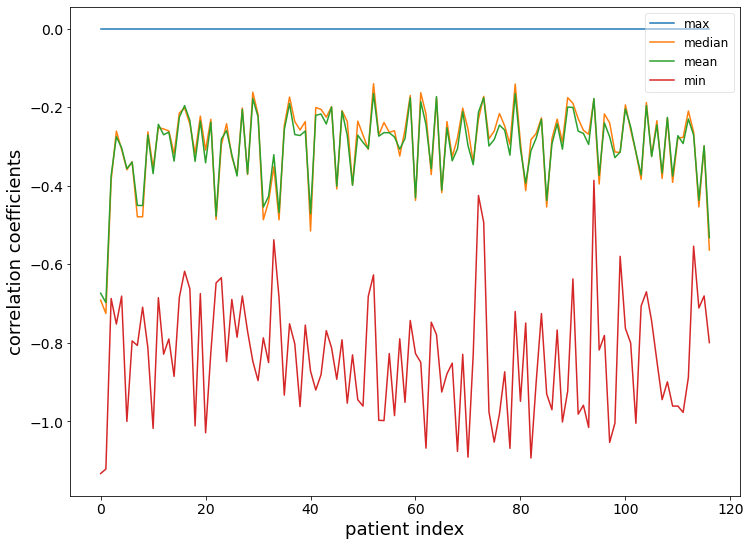

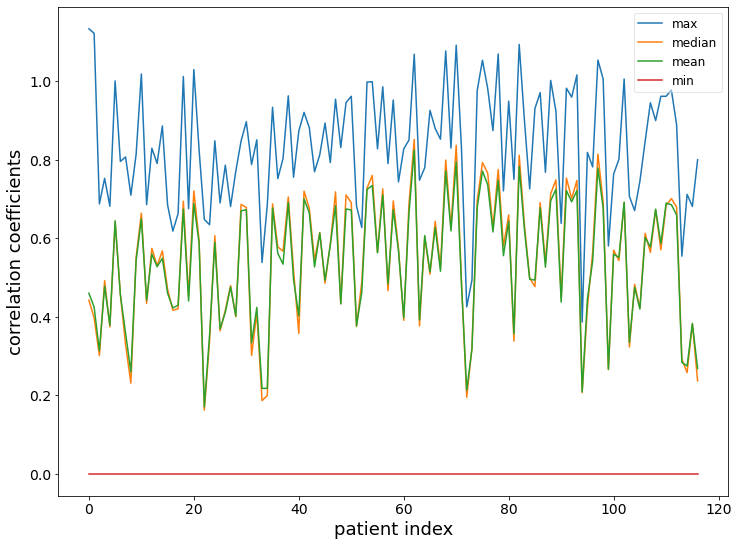

C:\Users\bird\Anaconda3\lib\site-packages\ipykernel_launcher.py:241: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


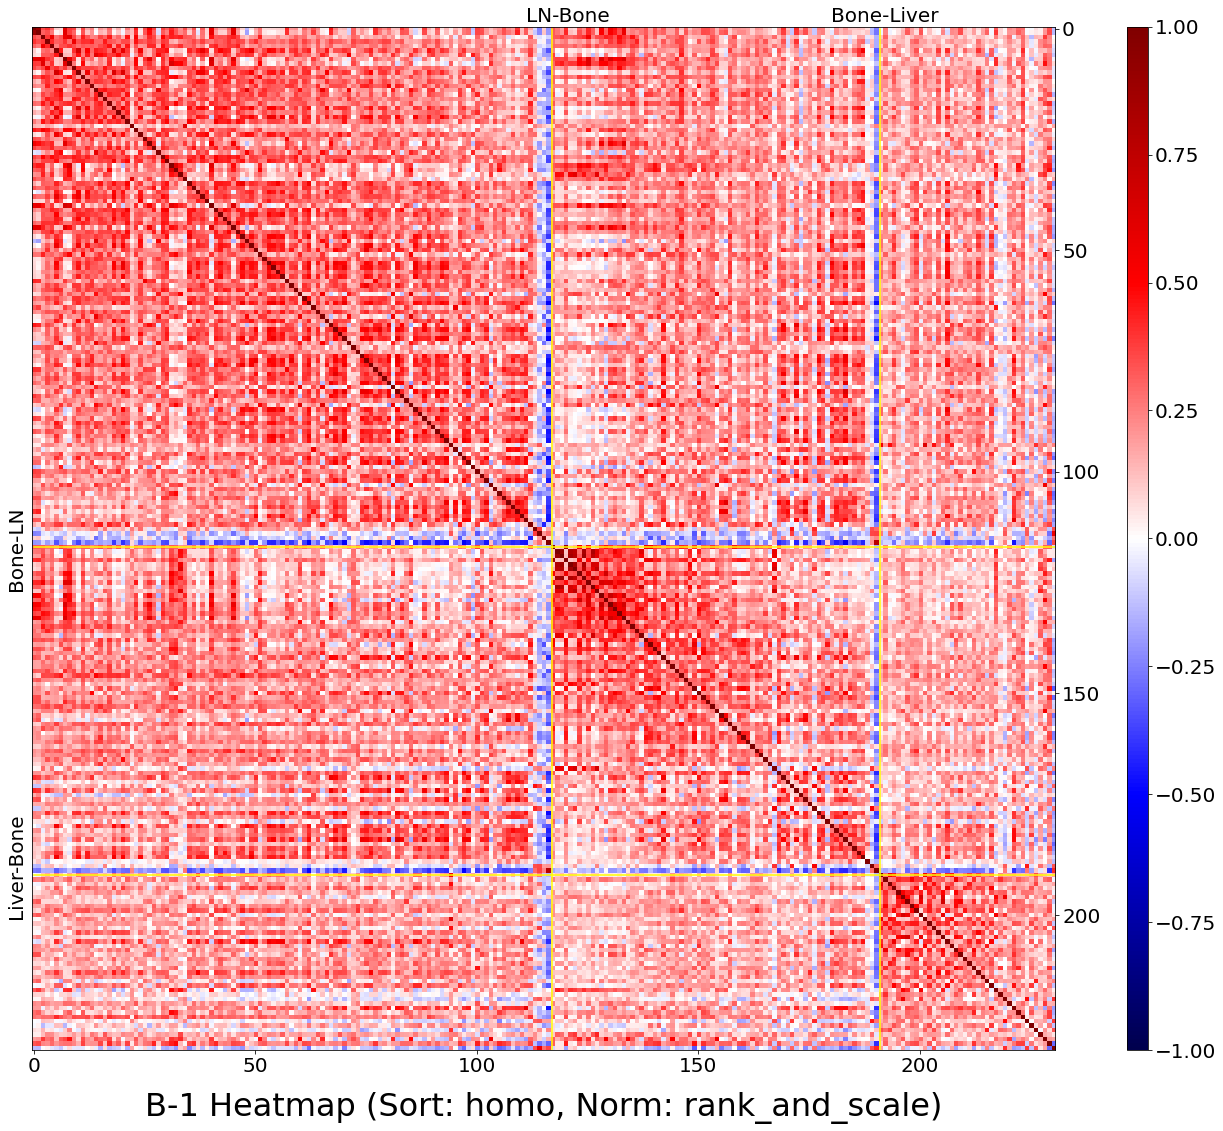

In [34]:
# mRNA_231_file = 'C:\\Users\\bird\\Desktop\\cancer_project_github\\cancer_data\\data_mRNA_231_sort_with_sensitive.csv'
# mRNA_231_df=pd.read_csv(mRNA_231_file)
# max_min_df = mRNA_231_df[['max','min','diff']]
# df1 = max_min_df.sort_values(['max', 'min'], ascending=[False, False])
# max_np = df1['max'].to_numpy()
# # max_np = np.log2(max_np+0.0001)
# max_np = scale(max_np, 0, 100)

# min_np = df1['min'].to_numpy()
# # min_np = np.log2(min_np+0.0001)
# min_np = scale(min_np, 0, 100)
# print(patient_np)
patient_np = np.asarray(patient_mRNA) 

def relative_plot_preprocess(scales, starnder, other_values):
    res = [[scales]*len(starnder)]
    for each in other_values:
        relative_list = [a - b + scales for a, b in zip(each, starnder)]
        res.append(relative_list)
    return res


def plot_ABC(patient_np, params):
    scheme, std, norm, sorts, norms= params
    if not scheme in sorts:
        scheme = ''
    if not norm in norms:
        norm = ''
    ref_1 = norms.get(norm)
    
    if norm:
        norm = '(Norm: ' + norm +')'
    else:
        norm = '(Norm: None)'
            
    max_np = patient_np.max(axis=0)
    min_np = patient_np.min(axis=0)
    diff_np = max_np - min_np
    media_np = np.median(patient_np, axis=0)
    mean_np = np.mean(patient_np, axis=0)
    
    max_min_df = pd.DataFrame({"max": max_np, "min": min_np, "media":media_np, "mean":mean_np})
     #===================================media=========================================
    
    df1 = max_min_df.sort_values(['media'], ascending=[False])
    max_np_sort = df1['max'].to_numpy()
    min_np_sort = df1['min'].to_numpy()
    media_np_sort = df1['media'].to_numpy()
    mean_np_sort = df1['mean'].to_numpy()
    scales = 100
    [media_np_sort, mean_np_sort, max_np_sort, min_np_sort] = \
        relative_plot_preprocess(scales, media_np_sort, [mean_np_sort, max_np_sort, min_np_sort ])
    

    plt.figure(figsize=(12,16))
    plt.rc('ytick',labelsize=14)
    plt.rc('xtick',labelsize=14)
    plt.scatter(list(range(len(max_np_sort))), max_np_sort, label='max',s=1)
    plt.scatter(list(range(len(max_np_sort))),mean_np_sort, label='mean',s=1)
    plt.scatter(list(range(len(max_np_sort))),media_np_sort, label='median',s=1)
    plt.scatter(list(range(len(max_np_sort))),min_np_sort, label='min',s=1)
    plt.legend(loc='lower right',  markerscale=5,fontsize=16)
    plt.ylabel('mRNA value', fontsize=18)
    plt.xlabel('mRNA index', fontsize=18)
    title =ref_1+' Plot A' + norm +', set standard median '
    plt.title(title, fontsize=22)
    
    plt.ylim(5, 1000)
    plt.yscale('log')#///
    plt.show()
    
    #===================================mean=========================================  
    df1 = max_min_df.sort_values(['mean'], ascending=[False])
    max_np_sort = df1['max'].to_numpy()
    min_np_sort = df1['min'].to_numpy()
    media_np_sort = df1['media'].to_numpy()
    mean_np_sort = df1['mean'].to_numpy()
    
    scales = 100
    [mean_np_sort, max_np_sort, min_np_sort, media_np_sort] = relative_plot_preprocess(scales, mean_np_sort, [max_np_sort, min_np_sort, media_np_sort])
   
    plt.figure(figsize=(12,16))
    plt.rc('ytick',labelsize=14)
    plt.rc('xtick',labelsize=14)
    plt.scatter(list(range(len(max_np_sort))), max_np_sort, label='max',s=1)
    plt.scatter(list(range(len(max_np_sort))),mean_np_sort, label='mean',s=1)
    plt.scatter(list(range(len(max_np_sort))),media_np_sort, label='median',s=1)
    plt.scatter(list(range(len(max_np_sort))),min_np_sort, label='min',s=1)
    plt.legend(loc='lower right', markerscale=5, fontsize=16)
    plt.ylabel('mRNA value', fontsize=18)
    plt.xlabel('mRNA index', fontsize=18)
    title =ref_1+' Plot A' + norm  +', set standard mean '
    plt.title(title, fontsize=22)
    
    plt.ylim(5, 1000)
    plt.yscale('log')#///
    plt.show()
   
    #=====================================min==========================================
    df1 = max_min_df.sort_values(['min', 'max'], ascending=[False, False])
    max_np_sort = df1['max'].to_numpy()
    min_np_sort = df1['min'].to_numpy()
    media_np_sort = df1['media'].to_numpy()
    mean_np_sort = df1['mean'].to_numpy()
    non_zeros = list(filter(lambda a: a !=0, min_np))
    print(len(non_zeros))
    
    scales = 1
    [min_np_sort, max_np_sort, mean_np_sort, media_np_sort] = relative_plot_preprocess(scales, min_np_sort, [max_np_sort, mean_np_sort, media_np_sort])
   
    plt.figure(figsize=(12,16))
    plt.rc('ytick',labelsize=14)
    plt.rc('xtick',labelsize=14)
    plt.scatter(list(range(len(max_np_sort))), max_np_sort, label='max',s=1)
    plt.scatter(list(range(len(max_np_sort))),mean_np_sort, label='mean',s=1)
    plt.scatter(list(range(len(max_np_sort))),media_np_sort, label='median',s=1)
    plt.scatter(list(range(len(max_np_sort))),min_np_sort, label='min',s=1)
    plt.legend(loc='upper right', markerscale=5, fontsize=16)
    plt.ylabel('mRNA value', fontsize=18)
    plt.xlabel('mRNA index', fontsize=18)
    title =ref_1+' Plot A' + norm  +', set standard min '
    plt.title(title, fontsize=22)
    
    plt.ylim(0.5, 1000)
    plt.yscale('log')#///
    plt.show()
    
    #=====================================max==========================================
    df1 = max_min_df.sort_values(['max'], ascending=[False])
    max_np_sort = df1['max'].to_numpy()
    min_np_sort = df1['min'].to_numpy()
    media_np_sort = df1['media'].to_numpy()
    mean_np_sort = df1['mean'].to_numpy()
    
#     scales = 100000
#     [max_np_sort, mean_np_sort, min_np_sort, media_np_sort] = relative_plot_preprocess(scales, max_np_sort, [mean_np_sort, min_np_sort, media_np_sort])
   
    plt.figure(figsize=(12,16))
    plt.rc('ytick',labelsize=14)
    plt.rc('xtick',labelsize=14)
    plt.scatter(list(range(len(max_np_sort))), max_np_sort, label='max',s=1)
    plt.scatter(list(range(len(max_np_sort))),mean_np_sort, label='mean',s=1)
    plt.scatter(list(range(len(max_np_sort))),media_np_sort, label='median',s=1)
    plt.scatter(list(range(len(max_np_sort))),min_np_sort, label='min',s=1)
    plt.legend(loc='upper right', markerscale=5, fontsize=16)
    plt.ylabel('mRNA value', fontsize=18)
    plt.xlabel('mRNA index', fontsize=18)
    title =ref_1+' Plot A' + norm  +', set standard max '
    plt.title(title, fontsize=22)
    
    plt.ylim(0.01, 10000)
    plt.yscale('log')#///
    plt.show()
#     =====================================================================================
    
    diff_min_df = pd.DataFrame({"diff": diff_np, "min": min_np})
    df2 = diff_min_df.sort_values(['diff', 'min'], ascending=[False, True])
    diff_np = df2['diff'].to_numpy()
#     print(diff_np)
#     diff_np = np.log(diff_np+0.00000001)

    plt.figure(figsize=(12,5))
    plt.ylabel('max_min difference', fontsize=16)
    plt.xlabel('mRNA index', fontsize=16)
    title =  ref_1+ ' Plot B' + norm
    plt.title(title, fontsize=22)
    plt.yscale('log')#////
    plt.plot(diff_np)
    plt.show()

    where_0 = np.where(diff_np == 0)#///
    diff_np[where_0] = 0.0001#///
    diff_np = np.log10(diff_np)#///
    
    n = 100
    s = diff_np.tolist()  # generate your data sample with N elements
    p, x = np.histogram(s, bins=n) # bin it into n bins
    x = x[:-1] + (x[1] - x[0])/2   # convert bin edges to centers
#     f = UnivariateSpline(x, p, s=n)
#     y = f(x)
    
    x = 10**x#///
    
#     cdfy = np.cumsum(y)
    plt.figure(figsize=(12,5))
    plt.xlabel('max-min', fontsize=16)
    plt.ylabel('NO. of mRNAs', fontsize=16)
    title = ref_1+' Plot C' + norm
    plt.title(title, fontsize=22)
    plt.xscale('log')#///
    plt.plot(x, p)
    plt.show()

def plot_heatmap(correlation_matrix, params):
#     r = np.corrcoef(patient_np, patient_np)

#     correlation_matrix = r[0:231, 0:231]
    # correlation_matrix = scale_floor(correlation_matrix, 0, 100) # normalisation method 1

#     print(correlation_matrix.mean(axis=0))
    scheme, sort_standad, norm, sorts, norms= params
    if not scheme in sorts:
        scheme = ''
    if not norm in norms:
        norm = ''
    ref_1 = norms.get(norm)
    ref_2 = sorts.get(scheme)
    if scheme: 
        scheme = '(Sort: '+scheme
        if norm:
            norm = ', Norm: ' + norm +')'
        else:
            norm = ', Norm: None)'
    else:
        scheme = '(Sort: None'
        if norm:
            norm = ', Norm: ' + norm +')'
        else:
            norm = ', Norm: None)'
        
    f = plt.figure(figsize=(20,20))
    
    plt.rc('xtick',labelsize=20)
    plt.rc('ytick',labelsize=20)
    
    ax = f.add_subplot(111)
    ax.yaxis.tick_right()

    # LN 117, Bone 74, Liver 40,Prostate 7,Lung 6
    plt.plot([117, 117], [0, 231], 'yellow')
    plt.plot([0, 244], [117, 117], 'yellow')
    plt.plot([191, 191], [0, 231], 'yellow')
    plt.plot([0, 244], [191, 191], 'yellow')
    plt.text(111, -1.5, 'LN-Bone', fontsize=20)
    plt.text(-6, 126, 'Bone-LN', rotation = 90, fontsize=20)
    plt.text(180, -1.5, 'Bone-Liver', fontsize=20)
    plt.text(-6,200, 'Liver-Bone', rotation = 90, fontsize=20)
    img = plt.imshow(correlation_matrix, cmap='seismic',vmin=-1, vmax=1, interpolation='nearest') #https://matplotlib.org/3.1.0/tutorials/colors/colormaps.html
    title = ref_1+'-'+ ref_2+' Heatmap ' + scheme + norm
    plt.title(title, y=-0.07, fontsize=32)
    ax = plt.subplot(111)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="2%", pad=1)

    plt.colorbar(img,cax=cax)
    plt.show()

def sample_norm_scale(patient_np):
    max_np = patient_np.max(axis=0)
    min_np = patient_np.min(axis=0)
    diff_np = max_np-min_np
    samples = []
#     print(patient_np.shape)
    
    for i in range(len(diff_np)):
        if diff_np[i]< 1 and diff_np[i]>0.1:
            samples.append(list(patient_np[:,i]))
            break
    for i in range(len(diff_np)):
        if diff_np[i]<3 and diff_np[i]>2:
            
            samples.append(list(patient_np[:,i]))
            break
    for i in range(len(diff_np)):
        if diff_np[i]<25 and diff_np[i]>18:
         
            samples.append(list(patient_np[:,i]))
            break
    for i in range(len(diff_np)):
        if diff_np[i]<150 and diff_np[i]>90:
         
            samples.append(list(patient_np[:,i]))
            break
    for i in range(len(diff_np)):
        if diff_np[i]<4000 and diff_np[i]>900 :
            samples.append(list(patient_np[:,i]))
          
            break

        
    samples = np.array(samples)
    max_np = samples.max(axis=1)
    min_np = samples.min(axis=1)
    diff_np = max_np-min_np
    diff_np = [ round(elem, 3) for elem in diff_np ]
    print(diff_np)
    print(samples.shape)
    def rd(x):
        return  (rankdata(x, method='dense') - 1).astype(int)
    samples_after = np.apply_along_axis(rd, 1, samples)
    samples_after = scale(samples_after.T,0,100)
    samples_after = samples_after.T
    for i in range(len(samples)):
        before = samples[i]
        after = samples_after[i]
        
        samples_df = pd.DataFrame({"before": before, "after": after})

        df1 = samples_df.sort_values(['before'], ascending=[False])
        before_sort = df1['before'].to_numpy()
        after_sort = df1['after'].to_numpy()
      
        plt.figure(figsize=(12,5))
        plt.rc('ytick',labelsize=14)
        plt.rc('xtick',labelsize=14)
        plt.plot(list(range(len(before_sort))), before_sort, label='before_norm')
        plt.plot(list(range(len(before_sort))),after_sort, label='after_norm')
        plt.legend(loc='upper right',  markerscale=5,fontsize=16)
        plt.ylabel('mRNA value', fontsize=18)
        plt.xlabel('patients index', fontsize=18)
        title = 'Rank normalisation, mRNA value max-min='+ str(diff_np[i])
        plt.title(title, fontsize=22)

#         plt.ylim(5, 1000)
#         plt.yscale('log')#///
        plt.show()
def plot_correlation_distr(correlation_matrix):
    print(correlation_matrix.shape)
    correlations = correlation_matrix.flatten()
    # print(len(correlations))
    correlations = list(filter(lambda a: a <0.99999, correlations))
    # print(len(correlations))

    n = 2000
    s = np.asarray(correlations)   # generate your data sample with N elements
    p, x = np.histogram(s, bins=n) # bin it into n = N//10 bins
    x = x[:-1] + (x[1] - x[0])/2   # convert bin edges to centers
    f = UnivariateSpline(x, p, s=n)
    y = f(x)/len(correlations)

    cdfy = np.cumsum(y)

    plt.figure(figsize=(20,8))
    plt.xlabel('correlation', fontsize=20)
    plt.ylabel('pdf', fontsize=20)
    plt.plot(x, y)
    plt.show()


    plt.figure(figsize=(20,8))
    plt.xlabel('correlation', fontsize=20)
    plt.ylabel('cdf', fontsize=20)
    plt.plot(x, cdfy)
    plt.show()  
def sort_standards(sort_std, corrs):
    if sort_std == 'mean':
        return np.mean(corrs, axis=0)
    elif sort_std == 'median':
        corrs = np.median(corrs, axis=0)
        return corrs
    elif sort_std == 'max':
        twmp = np.copy(corrs)
        twmp[twmp>0.999]=0
        return twmp.max(axis=0)
    elif sort_std == 'min':
        return corrs.min(axis=0)
    elif sort_std == 'weight':
        twmp = np.copy(corrs)
        twmp[twmp>0.999]=0
        twmp = list(twmp.max(axis=0))
        mini1 = list(corrs.min(axis=0))
        mean1 = list(np.mean(corrs, axis=0))
        median1 = list(np.median(corrs, axis=0))
        vrs = np.array([twmp, mini1, mean1, median1])
        vrs = np.var(vrs, axis=0)
#         print(vrs)
        return vrs
    else:
        return corrs.mean(axis=0)
    
def norm_and_sort_patients(patient, params ):
    scheme, sort_standard,  norm, sort_s, norm_s= params
    patient_np = np.copy(patient)
    if norm == 'linear_scale_and_bin':
        patient_np = np.floor(scale(patient_np, 0, 100))
    if norm == 'log_scale_and_bin':
        patient_np = np.log10(patient_np+0.0000001)
        patient_np = np.floor(scale(patient_np, 0, 100))
    if norm == 'rank_and_scale': 
        x = patient_np.T
        def rd(x):
            return  (rankdata(x, method='dense') - 1).astype(int)
        x = np.apply_along_axis(rd, 1, x)
        patient_np = scale(x.T,0,100)
        
      
    r = np.corrcoef(patient_np, patient_np)
    ranks = []
    
        
    if scheme == '':
        return r[0:231, 0:231], patient_np
    
    if scheme == 'homo':
#         print('homo')
#         corr_means = sort_standards(sort_standard, r[:231,:231])
#         print(corr_means.shape)
        correlation_matrix = r[0:117, 0:117] #LN 0-117, Bone 117-191, Liver 191-231
        corr_means = sort_standards(sort_standard, correlation_matrix)
#         print(corr_means)
        ranks = np.argsort(-corr_means)
        correlation_matrix = r[117:191, 117:191] #LN 0-117, Bone 117-191, Liver 191-231
        corr_means = sort_standards(sort_standard, correlation_matrix)
        ranks_t= np.argsort(-corr_means) + 117
        ranks = np.concatenate([ranks, ranks_t]) 
        correlation_matrix = r[191:231, 191:231] #LN 0-117, Bone 117-191, Liver 191-231
        corr_means = sort_standards(sort_standard, correlation_matrix)
        ranks_t = np.argsort(-corr_means) + 191
        ranks = np.concatenate([ranks, ranks_t]) 

    if scheme == 'hetero':
        correlation_matrix = r[ 0:231,0:117] #LN 0-117, Bone 117-191, Liver 191-231
        corr_means = sort_standards(sort_standard, correlation_matrix)
        ranks = np.argsort(-corr_means)
        correlation_matrix = r[0:231, 117:191] #LN 0-117, Bone 117-191, Liver 191-231
        corr_means = sort_standards(sort_standard, correlation_matrix)
        ranks_t= np.argsort(-corr_means) + 117
        ranks = np.concatenate([ranks, ranks_t]) 
        correlation_matrix = r[0:231, 191:231] #LN 0-117, Bone 117-191, Liver 191-231
        corr_means = sort_standards(sort_standard, correlation_matrix)
        ranks_t = np.argsort(-corr_means) + 191
        ranks = np.concatenate([ranks, ranks_t]) 

    correlation_matrix = r[0:231, 0:231]
    correlation_matrix = correlation_matrix[:, ranks][ranks]
    
#     correlation_matrix = np.around(correlation_matrix, decimals=2)
    
    return correlation_matrix, patient_np


def plot_onetype_cancer_statistics(corr_matrix):
    means = np.mean(corr_matrix, axis=0)
#     print(means)
    medians = np.median(corr_matrix, axis=0)
    mins= corr_matrix.min(axis=0)
    twmp = np.copy(corr_matrix)
    twmp[twmp>0.999]=0
    maxs= twmp.max(axis=0)
    
    
    plt.figure(figsize=(12,9))
    plt.rc('ytick',labelsize=14)
    plt.rc('xtick',labelsize=14)
    plt.plot(list(range(len(means))), maxs, label='max')
    plt.plot(list(range(len(means))),medians, label='median')
    plt.plot(list(range(len(means))),means, label='mean')
    plt.plot(list(range(len(means))),mins, label='min')
    

    plt.legend(loc='upper right', markerscale=5, fontsize=12, framealpha=0.5)
    plt.ylabel('correlation coefficients', fontsize=18)
    plt.xlabel('patient index', fontsize=18)
    plt.show()
#     =====================mean=====================
    means, medians, mins, maxs =relative_plot_preprocess(0, means, [medians, mins, maxs])
    plt.figure(figsize=(12,9))
    plt.rc('ytick',labelsize=14)
    plt.rc('xtick',labelsize=14)
    plt.plot(list(range(len(means))), maxs, label='max')
    plt.plot(list(range(len(means))),medians, label='median')
    plt.plot(list(range(len(means))),means, label='mean')
    plt.plot(list(range(len(means))),mins, label='min')
    

    plt.legend(loc='upper right', markerscale=5, fontsize=12, framealpha=0.5)
    plt.ylabel('correlation coefficients', fontsize=18)
    plt.xlabel('patient index', fontsize=18)
    plt.show()
#     =====================median====================

    medians, means, mins, maxs =relative_plot_preprocess(0, medians, [means, mins, maxs])
    plt.figure(figsize=(12,9))
    plt.rc('ytick',labelsize=14)
    plt.rc('xtick',labelsize=14)
    plt.plot(list(range(len(means))), maxs, label='max')
    plt.plot(list(range(len(means))),medians, label='median')
    plt.plot(list(range(len(means))),means, label='mean')
    plt.plot(list(range(len(means))),mins, label='min')
    

    plt.legend(loc='upper right', markerscale=5, fontsize=12, framealpha=0.5)
    plt.ylabel('correlation coefficients', fontsize=18)
    plt.xlabel('patient index', fontsize=18)
    plt.show()
#     =====================max====================

    maxs, medians, means, mins =relative_plot_preprocess(0,maxs,[medians, means, mins])
    plt.figure(figsize=(12,9))
    plt.rc('ytick',labelsize=14)
    plt.rc('xtick',labelsize=14)
    plt.plot(list(range(len(means))), maxs, label='max')
    plt.plot(list(range(len(means))),medians, label='median')
    plt.plot(list(range(len(means))),means, label='mean')
    plt.plot(list(range(len(means))),mins, label='min')
    

    plt.legend(loc='upper right', markerscale=5, fontsize=12, framealpha=0.5)
    plt.ylabel('correlation coefficients', fontsize=18)
    plt.xlabel('patient index', fontsize=18)
    plt.show()
#     =====================min====================

    mins, medians, means, maxs =relative_plot_preprocess(0,  mins, [ medians,means,maxs])
    plt.figure(figsize=(12,9))
    plt.rc('ytick',labelsize=14)
    plt.rc('xtick',labelsize=14)
    plt.plot(list(range(len(means))), maxs, label='max')
    plt.plot(list(range(len(means))),medians, label='median')
    plt.plot(list(range(len(means))),means, label='mean')
    plt.plot(list(range(len(means))),mins, label='min')
    

    plt.legend(loc='upper right', markerscale=5, fontsize=12, framealpha=0.5)
    plt.ylabel('correlation coefficients', fontsize=18)
    plt.xlabel('patient index', fontsize=18)
    plt.show()
    
    
sorts = {"":'0',
    "homo":'1',
    "hetero":"2"}

norms = {'': '0',
         'linear_scale_and_bin': 'A',
         'log_scale_and_bin': 'A',
         'rank_and_scale': 'B'
}

params = ['homo','mean', 'rank_and_scale', sorts, norms] # scheme = {'', 'hetero' 'homo'}, norm = {'','rank_and_scale', 'scale_and_bin_linear', 'log_scale_and_bin'}
origin_patient_np = patient_np
correlation_matrix, patient_np = norm_and_sort_patients(patient_np, params)#hetero homo scale_and_bin rank_and_scale

LN_matrix = correlation_matrix[:117,:117]
plot_onetype_cancer_statistics(LN_matrix)



# plot_correlation_distr(correlation_matrix)
plot_heatmap(correlation_matrix,params)

# plot_ABC(patient_np,params)

# samples = sample_norm_scale(origin_patient_np)
